In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
import numpy as np
import pandas as pd

In [58]:
df = pd.read_csv('/content/drive/MyDrive/Code-smell-severity-classification-main/merged dataset_FE_LM_GC_DC.csv',
                    sep=',', encoding='iso-8859-1')

## **PREDICTOR AND TARGET ATTRIBUTES**

In [59]:
predictors_chi = df.iloc[:, [10,11,13,14,15,17,19,21,22,23,25,30,31,33,34,35,37,40,44,54,60,61,62,63,64]].values
from sklearn.preprocessing import StandardScaler
predictors_chi_stand = StandardScaler().fit_transform(predictors_chi)

binary_target = df.iloc[:, 5].values
multiclass_target = df.iloc[:, 7].values

# **Binary Code Smell Detection**

# **CATBOOST**

https://catboost.ai/en/docs/

In [48]:
!pip install catboost

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from catboost import CatBoostClassifier
x_train_binary, x_test_binary, y_train_binary, y_test_binary = train_test_split(predictors_chi_stand, binary_target, test_size = 0.3, random_state = 0)
x_train_multiclass, x_test_multiclass, y_train_multiclass, y_test_multiclass = train_test_split(predictors_chi_stand, multiclass_target, test_size = 0.3, random_state = 0)


catboost = CatBoostClassifier(task_type='CPU', iterations=150, learning_rate=0.1, depth = 8, random_state = 5, eval_metric="Accuracy")
catboost.fit( x_train_binary, y_train_binary, plot=True, eval_set=(x_test_binary, y_test_binary))
predictions_cat = catboost.predict(x_test_binary)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9088000	test: 0.8438662	best: 0.8438662 (0)	total: 9.25ms	remaining: 1.38s
1:	learn: 0.9200000	test: 0.8847584	best: 0.8847584 (1)	total: 18.6ms	remaining: 1.37s
2:	learn: 0.9216000	test: 0.8661710	best: 0.8847584 (1)	total: 29.4ms	remaining: 1.44s
3:	learn: 0.9440000	test: 0.8959108	best: 0.8959108 (3)	total: 38.3ms	remaining: 1.4s
4:	learn: 0.9408000	test: 0.8884758	best: 0.8959108 (3)	total: 47.1ms	remaining: 1.36s
5:	learn: 0.9456000	test: 0.8847584	best: 0.8959108 (3)	total: 56ms	remaining: 1.34s
6:	learn: 0.9472000	test: 0.9070632	best: 0.9070632 (6)	total: 68ms	remaining: 1.39s
7:	learn: 0.9552000	test: 0.9033457	best: 0.9070632 (6)	total: 76.9ms	remaining: 1.36s
8:	learn: 0.9584000	test: 0.9033457	best: 0.9070632 (6)	total: 85.7ms	remaining: 1.34s
9:	learn: 0.9584000	test: 0.9033457	best: 0.9070632 (6)	total: 94.6ms	remaining: 1.32s
10:	learn: 0.9584000	test: 0.9070632	best: 0.9070632 (6)	total: 104ms	remaining: 1.31s
11:	learn: 0.9616000	test: 0.9070632	best: 0.907

              precision    recall  f1-score   support

         0.0       0.98      0.88      0.93       129
         1.0       0.90      0.99      0.94       140

    accuracy                           0.94       269
   macro avg       0.94      0.93      0.94       269
weighted avg       0.94      0.94      0.94       269



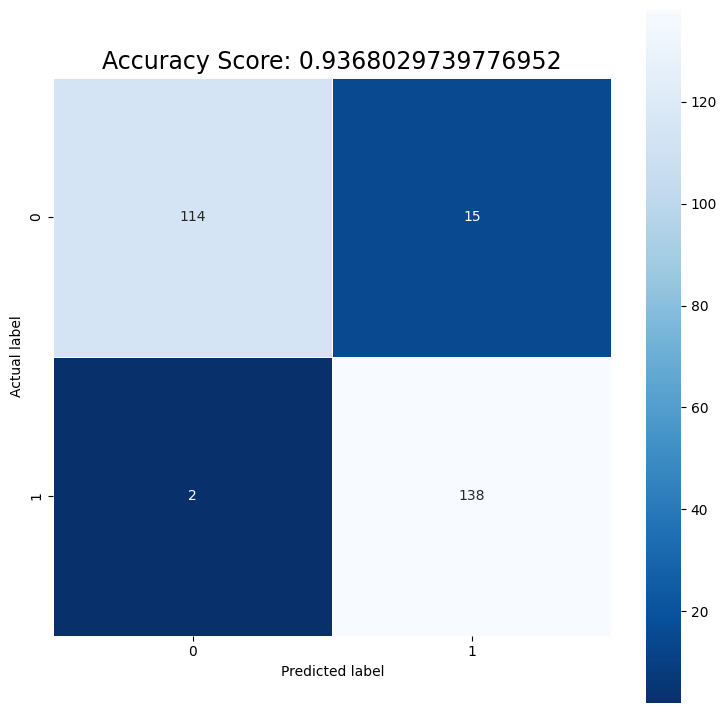

In [61]:
cm = confusion_matrix(y_test_binary, predictions_cat)

print(classification_report(y_test_binary, predictions_cat))

score = catboost.score(x_test_binary, y_test_binary)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

# **Exclude instances of no-smell from the training and test sets**


In [62]:
finish = False
while (finish == False):
  try:
    max = x_train_multiclass.shape[0]
    # Exclude instances of no-smell from the training set (targets)
    for i in range(0, max):
      if (y_train_multiclass[i] == 0):
        y_train_multiclass = np.delete(y_train_multiclass, i, axis = 0)
        x_train_multiclass = np.delete(x_train_multiclass, i, axis = 0)
        i = 0
        max = max - 1
    finish = True
    print("The deletion is over in the y_train set!")
  except:
    finish == False


finish = False
while (finish == False):
  try:
    max = x_test_multiclass.shape[0]
    # Exclude instances of no-smell from the test set (predictors)
    for i in range(0, max):
      if (y_test_multiclass[i] == 0):
        y_test_multiclass = np.delete(y_test_multiclass, i, axis = 0)
        x_test_multiclass = np.delete(x_test_multiclass, i, axis = 0)
        i = 0
        max = max - 1
    finish = True
    print("The deletion is over in the x_train set!")
  except:
    finish = False

The deletion is over in the y_train set!
The deletion is over in the x_train set!


# **Code Smell Severity Classification with two of the best classifiers**

# **CATBOOST**

In [9]:
from sklearn.model_selection import GridSearchCV
model = CatBoostClassifier(task_type='CPU', random_state = 5)

param_grid = dict(
    iterations=[50, 100, 150, 200],
    learning_rate=[0.01, 0.05, 0.1, 0.2, 0.5],
    depth=[4,5,6,7,8,9,10],
    )

grid_search = GridSearchCV(model, param_grid, scoring='f1_macro')
grid_search.fit(x_train_multiclass, y_train_multiclass)
print(grid_search.best_params_)

Streaming output truncated to the last 5000 lines.
151:	learn: 1.3603322	total: 46.9s	remaining: 14.8s
152:	learn: 1.3551735	total: 47.2s	remaining: 14.5s
153:	learn: 1.3510521	total: 47.5s	remaining: 14.2s
154:	learn: 1.3475310	total: 47.8s	remaining: 13.9s
155:	learn: 1.3439937	total: 48.1s	remaining: 13.6s
156:	learn: 1.3399587	total: 48.4s	remaining: 13.2s
157:	learn: 1.3365731	total: 48.6s	remaining: 12.9s
158:	learn: 1.3331619	total: 48.9s	remaining: 12.6s
159:	learn: 1.3297742	total: 49.2s	remaining: 12.3s
160:	learn: 1.3258921	total: 49.5s	remaining: 12s
161:	learn: 1.3229565	total: 49.8s	remaining: 11.7s
162:	learn: 1.3194016	total: 50s	remaining: 11.4s
163:	learn: 1.3148026	total: 50.5s	remaining: 11.1s
164:	learn: 1.3111169	total: 51s	remaining: 10.8s
165:	learn: 1.3073031	total: 51.5s	remaining: 10.5s
166:	learn: 1.3041288	total: 52s	remaining: 10.3s
167:	learn: 1.3013407	total: 52.4s	remaining: 9.98s
168:	learn: 1.2977778	total: 52.9s	remaining: 9.7s
169:	learn: 1.2946164	

In [63]:
catboost = CatBoostClassifier(task_type='CPU', iterations=150, learning_rate=0.5, depth = 8, random_state = 5, eval_metric="Accuracy")
catboost.fit(x_train_multiclass, y_train_multiclass, plot=True, eval_set=(x_test_multiclass, y_test_multiclass))

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
predictions_cat = catboost.predict(x_test_multiclass)
print("Accuracy: %.2f%%" % (accuracy_score(y_test_multiclass, predictions_cat) * 100.0))


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6832845	test: 0.6071429	best: 0.6071429 (0)	total: 83.3ms	remaining: 12.4s
1:	learn: 0.6950147	test: 0.6000000	best: 0.6071429 (0)	total: 207ms	remaining: 15.3s
2:	learn: 0.7360704	test: 0.6071429	best: 0.6071429 (0)	total: 349ms	remaining: 17.1s
3:	learn: 0.7478006	test: 0.6357143	best: 0.6357143 (3)	total: 486ms	remaining: 17.8s
4:	learn: 0.7800587	test: 0.6357143	best: 0.6357143 (3)	total: 633ms	remaining: 18.3s
5:	learn: 0.7800587	test: 0.6285714	best: 0.6357143 (3)	total: 777ms	remaining: 18.6s
6:	learn: 0.8093842	test: 0.6642857	best: 0.6642857 (6)	total: 907ms	remaining: 18.5s
7:	learn: 0.8211144	test: 0.6642857	best: 0.6642857 (6)	total: 1.04s	remaining: 18.4s
8:	learn: 0.8328446	test: 0.6571429	best: 0.6642857 (6)	total: 1.18s	remaining: 18.4s
9:	learn: 0.8328446	test: 0.6857143	best: 0.6857143 (9)	total: 1.31s	remaining: 18.3s
10:	learn: 0.8592375	test: 0.6642857	best: 0.6857143 (9)	total: 1.46s	remaining: 18.4s
11:	learn: 0.8709677	test: 0.6642857	best: 0.6857143

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         6
         2.0       0.62      0.42      0.50        12
         3.0       1.00      1.00      1.00         1
         4.0       0.00      0.00      0.00         2
         5.0       0.79      0.93      0.86        29
         6.0       0.64      1.00      0.78         7
         7.0       0.83      0.62      0.71         8
         8.0       0.72      0.72      0.72        25
         9.0       0.60      0.75      0.67        12
        10.0       0.00      0.00      0.00         0
        11.0       0.43      0.30      0.35        10
        12.0       0.83      0.89      0.86        28

    accuracy                           0.71       140
   macro avg       0.54      0.55      0.54       140
weighted avg       0.68      0.71      0.69       140



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

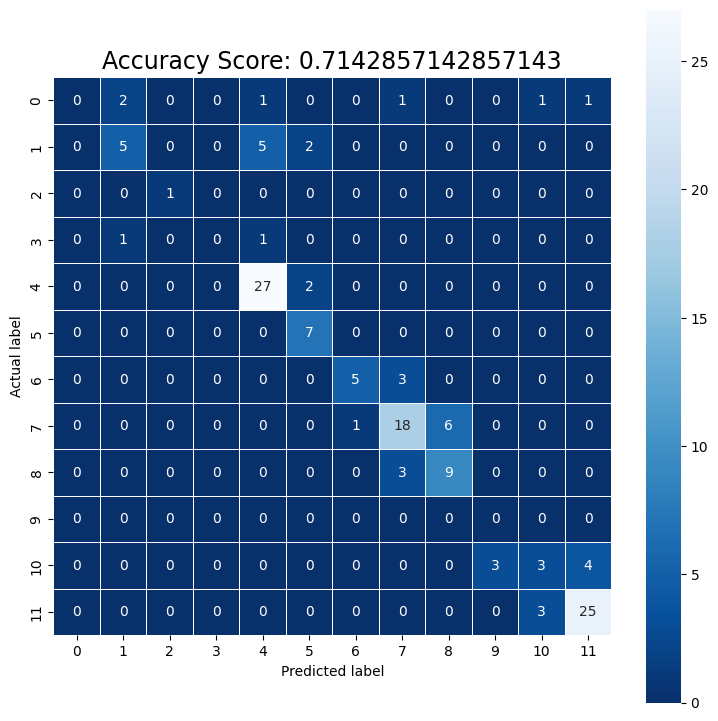

In [64]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

cm = confusion_matrix(y_test_multiclass, predictions_cat)

print(classification_report(y_test_multiclass, predictions_cat))

score = catboost.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

# **XGBoost**

# Prepare training and test set for applying XGBoost

In [65]:
for j in range(len(y_train_multiclass)):
    if y_train_multiclass[j] == 1.0:
      y_train_multiclass[j]= 0.0

for j in range(len(y_test_multiclass)):
    if y_test_multiclass[j] == 1.0:
      y_test_multiclass[j]= 0.0

for j in range(len(y_train_multiclass)):
    if y_train_multiclass[j] == 2.0:
      y_train_multiclass[j]= 1.0

for j in range(len(y_test_multiclass)):
    if y_test_multiclass[j] == 2.0:
      y_test_multiclass[j]= 1.0

for j in range(len(y_train_multiclass)):
    if y_train_multiclass[j] == 3.0:
      y_train_multiclass[j]= 2.0

for j in range(len(y_test_multiclass)):
    if y_test_multiclass[j] == 3.0:
      y_test_multiclass[j]= 2.0

for j in range(len(y_train_multiclass)):
    if y_train_multiclass[j] == 4.0:
      y_train_multiclass[j]= 3.0

for j in range(len(y_test_multiclass)):
    if y_test_multiclass[j] == 4.0:
      y_test_multiclass[j]= 3.0

for j in range(len(y_train_multiclass)):
    if y_train_multiclass[j] == 5.0:
      y_train_multiclass[j]= 4.0

for j in range(len(y_test_multiclass)):
    if y_test_multiclass[j] == 5.0:
      y_test_multiclass[j]= 4.0

for j in range(len(y_train_multiclass)):
    if y_train_multiclass[j] == 6.0:
      y_train_multiclass[j]= 5.0

for j in range(len(y_test_multiclass)):
    if y_test_multiclass[j] == 6.0:
      y_test_multiclass[j]= 5.0

for j in range(len(y_train_multiclass)):
    if y_train_multiclass[j] == 7.0:
      y_train_multiclass[j]= 6.0

for j in range(len(y_test_multiclass)):
    if y_test_multiclass[j] == 7.0:
      y_test_multiclass[j]= 6.0

for j in range(len(y_train_multiclass)):
    if y_train_multiclass[j] == 8.0:
      y_train_multiclass[j]= 7.0

for j in range(len(y_test_multiclass)):
    if y_test_multiclass[j] == 8.0:
      y_test_multiclass[j]= 7.0

for j in range(len(y_train_multiclass)):
    if y_train_multiclass[j] == 9.0:
      y_train_multiclass[j]= 8.0

for j in range(len(y_test_multiclass)):
    if y_test_multiclass[j] == 9.0:
      y_test_multiclass[j]= 8.0

for j in range(len(y_train_multiclass)):
    if y_train_multiclass[j] == 10.0:
      y_train_multiclass[j]= 9.0

for j in range(len(y_test_multiclass)):
    if y_test_multiclass[j] == 10.0:
      y_test_multiclass[j]= 9.0

for j in range(len(y_train_multiclass)):
    if y_train_multiclass[j] == 11.0:
      y_train_multiclass[j]= 10.0

for j in range(len(y_test_multiclass)):
    if y_test_multiclass[j] == 11.0:
      y_test_multiclass[j]= 10.0

for j in range(len(y_train_multiclass)):
    if y_train_multiclass[j] == 12.0:
      y_train_multiclass[j]= 11.0

for j in range(len(y_test_multiclass)):
    if y_test_multiclass[j] == 12.0:
      y_test_multiclass[j]= 11.0

In [66]:
from xgboost import XGBClassifier

In [16]:
from sklearn.model_selection import GridSearchCV

modelo = XGBClassifier(objective='multi:softprob', num_class=12, random_state=3)

param_grid = dict(
    n_estimators=[50, 100, 150, 200],
    max_depth=[1,2,3,4,5],
    learning_rate=[0.01, 0.05, 0.1, 0.2, 0.5]
    )

# Configuring the search with Grid search
grid_search = GridSearchCV(modelo, param_grid, scoring='f1_macro')

# Configuring the best Multiclass hyperparameters
grid_search.fit(x_train_multiclass, y_train_multiclass)

# Best Hyperparameters
print(grid_search.best_params_)

{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}


              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67         6
         1.0       0.54      0.58      0.56        12
         2.0       1.00      1.00      1.00         1
         3.0       0.00      0.00      0.00         2
         4.0       0.79      0.76      0.77        29
         5.0       0.64      1.00      0.78         7
         6.0       0.75      0.75      0.75         8
         7.0       0.83      0.76      0.79        25
         8.0       0.71      0.83      0.77        12
        10.0       0.62      0.50      0.56        10
        11.0       0.83      0.89      0.86        28

    accuracy                           0.75       140
   macro avg       0.70      0.69      0.68       140
weighted avg       0.75      0.75      0.74       140



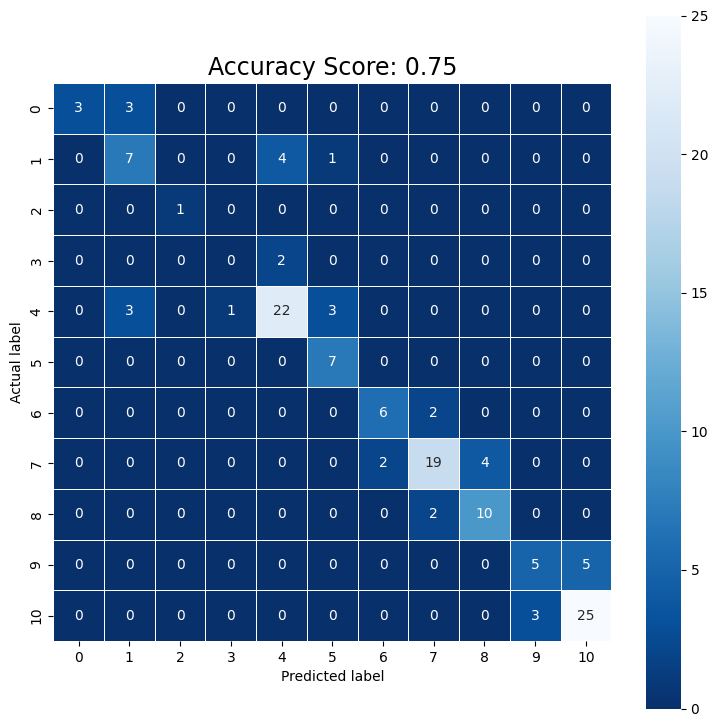

In [67]:
xg = XGBClassifier(learning_rate=0.2, max_depth=3, n_estimators=50, objective='multi:softprob', num_class=12, random_state=3)
xg.fit(x_train_multiclass,y_train_multiclass)
predictions_xg = xg.predict(x_test_multiclass)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

cm = confusion_matrix(y_test_multiclass, predictions_xg)

print(classification_report(y_test_multiclass, predictions_xg))

score = xg.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()
